<a href="https://colab.research.google.com/github/collinwa/MPCCA/blob/model_refactor/analysis_notebooks/analyze_mesa_mpcca_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import mpcca_collin.MPCCA.micca_model as micca
import mpcca_collin.MPCCA.model as model
import mpcca_collin.MPCCA.mp_simulation as mp_simulation

from scipy import stats
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_printoptions(linewidth = 200)
np.set_printoptions(linewidth = 200)

In [ ]:
methyl_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/methyl_cca_collated.json"
metab_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/metab_cca_collated.json"
exp_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/exp_cca_collated.json"
geno_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/geno_cca_collated.json"
protein_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/protein_cca_collated.json"
meta_df_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/metadata_cca_collated.json"
pheno_df_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/phenotypes_cca_collated.json"

In [ ]:
pheno_df = pd.read_json(pheno_df_save_fn)
meta_df = pd.read_json(meta_df_save_fn)
geno_data = pd.read_json(geno_data_save_fn)
metab_data = pd.read_json(metab_data_save_fn)
protein_data = pd.read_json(protein_data_save_fn)
exp_data = pd.read_json(exp_data_save_fn)
methyl_data = pd.read_json(methyl_data_save_fn)

n_inds = geno_data.shape[0]

In [ ]:
geno_pca = micca.pca(torch.from_numpy(geno_data.values))
metab_pca = micca.pca(torch.from_numpy(metab_data.values))
protein_pca = micca.pca(torch.from_numpy(protein_data.values))
exp_pca = micca.pca(torch.from_numpy(exp_data.values))
methyl_pca = micca.pca(torch.from_numpy(methyl_data.values))

In [ ]:
# TODO(brielin): check weighting these by lambda_pc
geno_ds = geno_pca.U*np.sqrt(n_inds-1)  # Not using MP dim, using given 11 PCs.
exp_ds = exp_pca.U[:, 0:exp_pca.mp_dim]*np.sqrt(n_inds-1)  # 33
methyl_ds = methyl_pca.U[:, 0:methyl_pca.mp_dim]*np.sqrt(n_inds-1)  # 49
metab_ds = metab_pca.U[:, 0:metab_pca.mp_dim]*np.sqrt(n_inds-1)  # 66
protein_ds = protein_pca.U[:, 0:protein_pca.mp_dim]*np.sqrt(n_inds-1)  # 29
datasets = [geno_ds, exp_ds, methyl_ds, metab_ds, protein_ds]

In [ ]:
meta_df = meta_df.sort_values(
    by=['sidno', 'NWDID', 'num_nans']).drop_duplicates(
        subset='NWDID').set_index('NWDID').loc[geno_data.index].drop(
            columns=['index', 'sidno', 'Metabolomics', 'Methylomics',
                     'Proteomics', 'Transcriptomics_PBMC', 'num_nans'])

In [ ]:
analysis_cols = ['Sex', 'Race', 'Age', 'bmi1c', 'RQS', 'adapter_contam_pct',
                 'seq_center', 'column_2', 'column_3', 'Summary.batch',
                 'Batch_scan', 'Bcell', 'CD4T', 'CD8T', 'Eos', 'Mono', 'Neu',
                 'NK', 'B cells', 'Plasma cells', 'T cells', 'NK cells',
                 'Monocytes', 'Macrophages', 'Dendritic cells', 'Mast cells',
                 'Eosinophils', 'Neutrophils']
meta_df = meta_df[analysis_cols]
meta_df_dummies = pd.get_dummies(meta_df)

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print('gpu available: using {}'.format(device))

y_concat = torch.cat(datasets, axis=1).double()

# initialize dataset dimension parameters 
x_dims = torch.tensor([4, 18, 34, 51, 14])
y_dims = torch.tensor([ds.shape[1] for ds in datasets])
d = 15  # low dimensional shared structure
n_steps = 1000

W_model, L_model, Phi_model = model.fit_model(y_dims, x_dims, datasets, d, y_concat, n_inds, steps=n_steps, device=device, toprint=100, method="stable")
W_model = W_model.cpu()
L_model = L_model.cpu()
Phi_model = Phi_model.cpu()

0/1000: (Wtprime-Wt)_F: 33.49573100355905 (Ltprime-Lt)_F: 78.24289634503577 (Phi_tprime-Phi_t)_F: 0.3285129430733614
100/1000: (Wtprime-Wt)_F: 0.09970493044970263 (Ltprime-Lt)_F: 0.05304032494518447 (Phi_tprime-Phi_t)_F: 0.01750151638037412
200/1000: (Wtprime-Wt)_F: 0.02610351990073659 (Ltprime-Lt)_F: 0.017089009040765723 (Phi_tprime-Phi_t)_F: 0.005608336813655402
300/1000: (Wtprime-Wt)_F: 0.014639033534625957 (Ltprime-Lt)_F: 0.009064364902072118 (Phi_tprime-Phi_t)_F: 0.001683661039784966
400/1000: (Wtprime-Wt)_F: 0.009774053119809795 (Ltprime-Lt)_F: 0.005939075252812453 (Phi_tprime-Phi_t)_F: 0.0008456661513151863
500/1000: (Wtprime-Wt)_F: 0.004564772222180901 (Ltprime-Lt)_F: 0.0019468150743399929 (Phi_tprime-Phi_t)_F: 0.0005778314171353547
600/1000: (Wtprime-Wt)_F: 0.0019838640251019723 (Ltprime-Lt)_F: 0.0006087332695434008 (Phi_tprime-Phi_t)_F: 0.00043266016978979336
700/1000: (Wtprime-Wt)_F: 0.0010041345587318657 (Ltprime-Lt)_F: 0.00042640988540147153 (Phi_tprime-Phi_t)_F: 0.0003651

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# [geno_pca, exp_pca, methyl_pca, metab_pca, protein_pca]
posterior_z, posterior_x = model.project_latent(W_model, L_model, Phi_model, d, y_concat)
posterior_z_geno, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 0)
posterior_z_exp, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 1)
posterior_z_methyl, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 2)
posterior_z_metab, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 3)
posterior_z_protein, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 4)

# get the interset correlation as per Parra 2018
latent_data_list = [posterior_z_geno, posterior_z_exp, posterior_z_methyl, posterior_z_metab, posterior_z_protein]
rho, rb, rw = model.compute_ISC(latent_data_list)

In [ ]:
print(rho)

tensor([0.4476, 0.4405, 0.4455, 0.5761, 0.4424, 0.5582, 0.3866, 0.4730, 0.5469, 0.4650, 0.3880, 0.6193, 0.3915, 0.4739, 0.4032])


In [ ]:
x_dimsum = np.cumsum(x_dims)

Z_orth = torch.linalg.svd(posterior_z, full_matrices=False).U
X_geno_orth = torch.linalg.svd(posterior_x[:, 0:x_dimsum[0]], full_matrices=False).U
X_exp_orth = torch.linalg.svd(posterior_x[:, x_dimsum[0]:x_dimsum[1]], full_matrices=False).U
X_methyl_orth = torch.linalg.svd(posterior_x[:, x_dimsum[1]:x_dimsum[2]], full_matrices=False).U
X_metab_orth = torch.linalg.svd(posterior_x[:, x_dimsum[2]:x_dimsum[3]], full_matrices=False).U
X_protein_orth = torch.linalg.svd(posterior_x[:, x_dimsum[3]:x_dimsum[4]], full_matrices=False).U
latent_data_list = [posterior_z_geno, posterior_z_exp, posterior_z_methyl, posterior_z_metab, posterior_z_protein]
rho, rb, rw = model.compute_ISC(latent_data_list)

In [ ]:
plot_dims = [4, 7, 13, 17 , 5]
colnames_all = ['Z_' + str(i) for i in range(d)] + \
    ['X_geno_' + str(i) for i in range(x_dims[0])] + \
    ['X_exp_' + str(i) for i in range(x_dims[1])] + \
    ['X_methyl_' + str(i) for i in range(x_dims[2])] + \
    ['X_metab_' + str(i) for i in range(x_dims[3])] + \
    ['X_protein_' + str(i) for i in range(x_dims[4])]

data = torch.cat([Z_orth, X_geno_orth, X_exp_orth, X_methyl_orth, X_metab_orth, X_protein_orth], 1)
data_df = pd.DataFrame(data.numpy(), columns = colnames_all, index=meta_df_dummies.index)


show_cols = ['Z_' + str(i) for i in range(d)] + \
    ['X_geno_' + str(i) for i in range(plot_dims[0])] + \
    ['X_exp_' + str(i) for i in range(plot_dims[1])] + \
    ['X_methyl_' + str(i) for i in range(plot_dims[2])] + \
    ['X_metab_' + str(i) for i in range(plot_dims[3])] + \
    ['X_protein_' + str(i) for i in range(plot_dims[4])]
data_df = data_df[show_cols]
prob_res_df = pd.concat([meta_df_dummies, data_df], axis=1)

<AxesSubplot:>

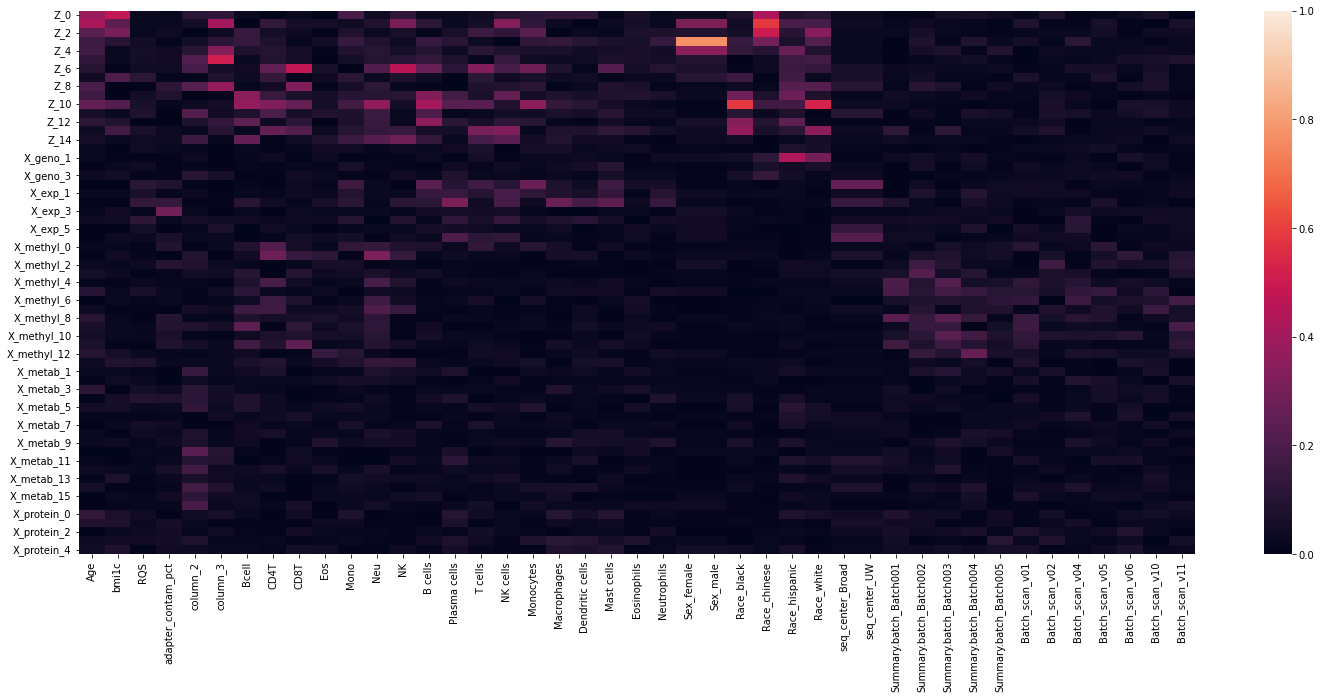

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = show_cols
cor_cols = meta_df_dummies.columns
data = abs(np.corrcoef(prob_res_df.fillna(prob_res_df.mean())[data_cols], prob_res_df.fillna(prob_res_df.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)

In [ ]:
prob_res_df['Race'] = meta_df.Race
prob_res_df['Sex'] = meta_df.Sex
prob_res_df['seq_center'] = meta_df.seq_center

<AxesSubplot:xlabel='Z_3', ylabel='Z_4'>

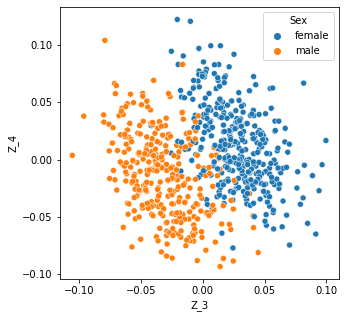

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=prob_res_df, x='Z_3', y='Z_4', hue='Sex')

<AxesSubplot:xlabel='Z_0', ylabel='Z_1'>

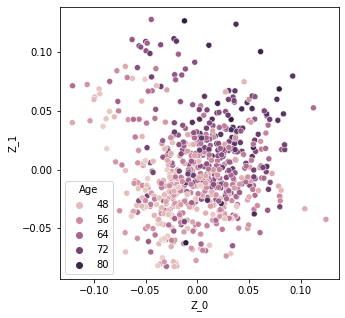

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=prob_res_df, x='Z_0', y='Z_1', hue='Age')

In [ ]:
# pheno_df = pheno_df.loc[meta_df.index].drop(columns=['hba1c'])
pheno_df_dummies = pd.get_dummies(pheno_df)
prob_pheno_df = pd.concat([pheno_df_dummies, data_df], axis=1)

<AxesSubplot:>

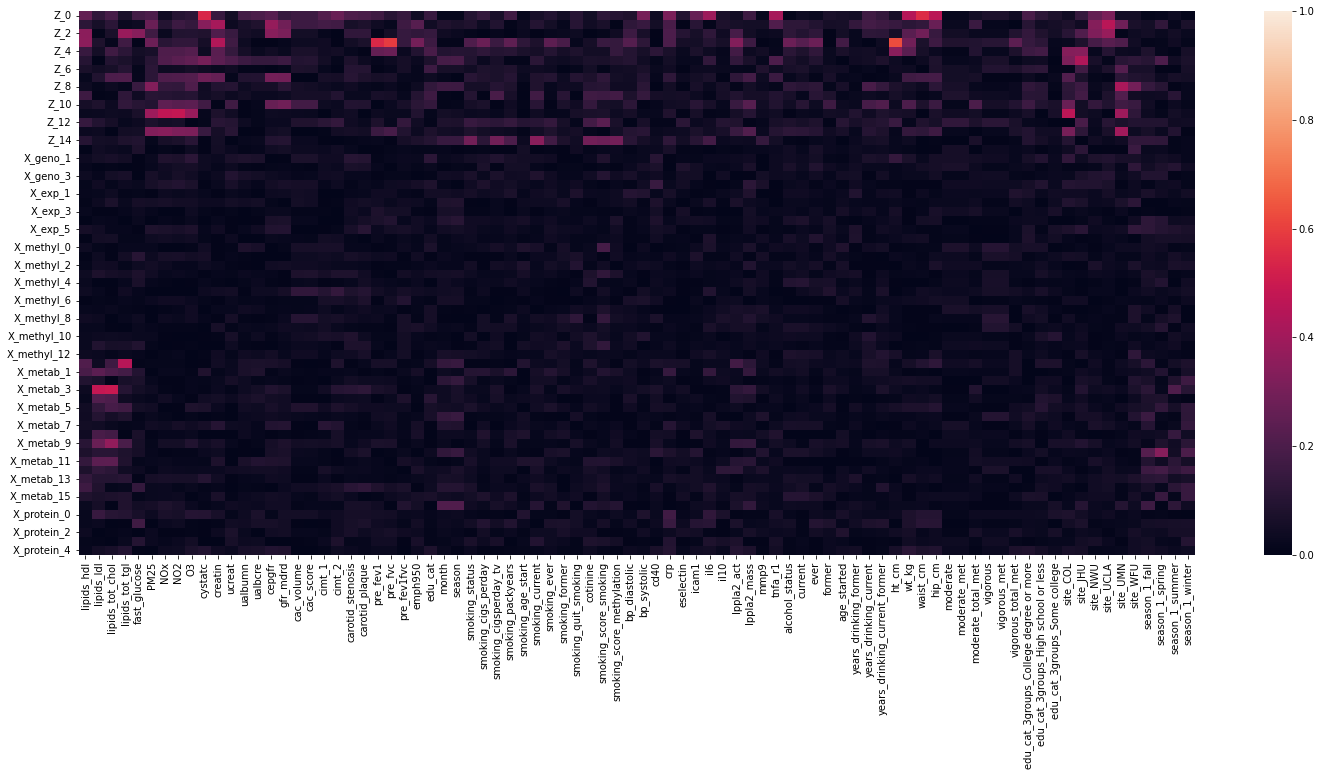

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = show_cols
cor_cols = pheno_df_dummies.columns
data = abs(np.corrcoef(prob_pheno_df.fillna(prob_pheno_df.mean())[data_cols], prob_pheno_df.fillna(prob_pheno_df.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)
# sns.heatmap(space_cov_cor)

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    print('gpu available: using {}'.format(device))

y_concat = torch.cat(datasets, axis=1).double()

# initialize dataset dimension parameters 
x_dims = torch.tensor(c_private)  # low dimensional private structure
y_dims = torch.tensor([ds.shape[1] for ds in datasets])
d = c_shared  # low dimensional shared structure
n_steps = 500

W_model, L_model, Phi_model = model.fit_model(y_dims, x_dims, datasets, d, y_concat, n_inds, steps=1000, device=device, toprint=100, method="stable")
W_model = W_model.cpu()
L_model = L_model.cpu()
Phi_model = Phi_model.cpu()

0/1000: (Wtprime-Wt)_F: 31.65679486358825 (Ltprime-Lt)_F: 75.85420351723934 (Phi_tprime-Phi_t)_F: 0.25736076865443785
100/1000: (Wtprime-Wt)_F: 0.13511008765859164 (Ltprime-Lt)_F: 0.0743957984743329 (Phi_tprime-Phi_t)_F: 0.018191624178254796
200/1000: (Wtprime-Wt)_F: 0.03343594167675472 (Ltprime-Lt)_F: 0.01973332293089793 (Phi_tprime-Phi_t)_F: 0.004440205321189318
300/1000: (Wtprime-Wt)_F: 0.015228091829260517 (Ltprime-Lt)_F: 0.009707800369437195 (Phi_tprime-Phi_t)_F: 0.0017882288151989793
400/1000: (Wtprime-Wt)_F: 0.011206551964688588 (Ltprime-Lt)_F: 0.007355185005782277 (Phi_tprime-Phi_t)_F: 0.001306406104576034
500/1000: (Wtprime-Wt)_F: 0.005798444220386767 (Ltprime-Lt)_F: 0.0031536919943017014 (Phi_tprime-Phi_t)_F: 0.0014403643481538423
600/1000: (Wtprime-Wt)_F: 0.0020368456615190975 (Ltprime-Lt)_F: 0.001481724336448202 (Phi_tprime-Phi_t)_F: 0.0009854483939824902
700/1000: (Wtprime-Wt)_F: 0.000931072478810676 (Ltprime-Lt)_F: 0.0009229808395174376 (Phi_tprime-Phi_t)_F: 0.00068921336

<Figure size 1080x1080 with 0 Axes>

In [ ]:
# [geno_pca, exp_pca, methyl_pca, metab_pca, protein_pca]
posterior_z, posterior_x = model.project_latent(W_model, L_model, Phi_model, d, y_concat)
# posterior_z_exp, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 1)
# posterior_z_methyl, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 2)
# posterior_z_metab, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 3)
# posterior_z_protein, _ = model.project_latent_individual(W_model, L_model, Phi_model, d, y_concat, x_dims, y_dims, 4)

# # get the interset correlation as per Parra 2018
# latent_data_list = [posterior_z_geno, posterior_z_exp, posterior_z_methyl, posterior_z_metab, posterior_z_protein]
# rho, rb, rw = model.compute_ISC(latent_data_list)

In [ ]:
x_dimsum = np.cumsum(x_dims)

Z_orth = torch.linalg.svd(posterior_z, full_matrices=False).U
# X_geno_orth = torch.linalg.svd(posterior_x[:, 0:x_dimsum[0]], full_matrices=False).U
X_exp_orth = torch.linalg.svd(posterior_x[:, 0:x_dimsum[0]], full_matrices=False).U
X_methyl_orth = torch.linalg.svd(posterior_x[:, x_dimsum[0]:x_dimsum[1]], full_matrices=False).U
X_metab_orth = torch.linalg.svd(posterior_x[:, x_dimsum[1]:x_dimsum[2]], full_matrices=False).U
X_protein_orth = torch.linalg.svd(posterior_x[:, x_dimsum[2]:x_dimsum[3]], full_matrices=False).U

In [ ]:
data = torch.cat([Z_orth, X_exp_orth, X_methyl_orth, X_metab_orth, X_protein_orth], 1).numpy()
colnames = ['Z_' + str(i) for i in range(c_shared)] + \
    ['X_exp_' + str(i) for i in range(x_dims[0])] + \
    ['X_methyl_' + str(i) for i in range(x_dims[1])] + \
    ['X_metab_' + str(i) for i in range(x_dims[2])] + \
    ['X_protein_' + str(i) for i in range(x_dims[3])]
ZX_df = pd.DataFrame(data, columns=colnames, index=meta_df_dummies.index)
orth_res = pd.concat([meta_df_dummies, ZX_df], axis=1)

<AxesSubplot:>

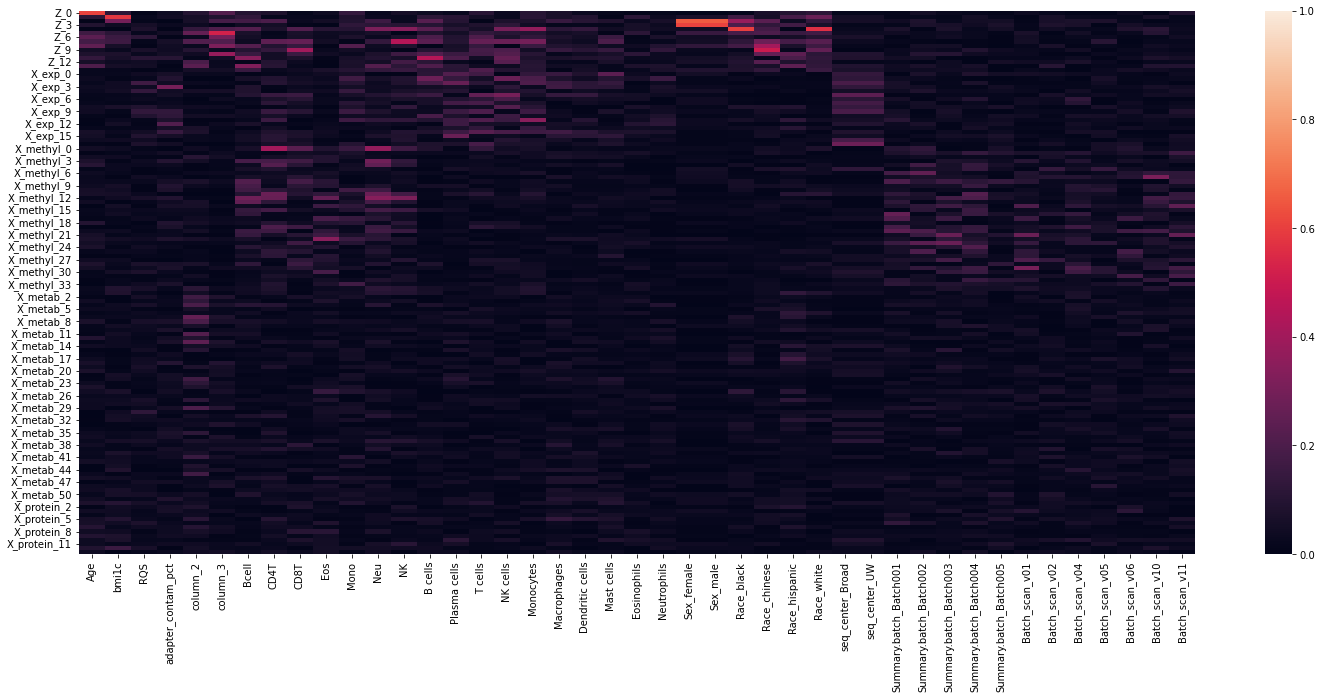

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = colnames
cor_cols = meta_df_dummies.columns
data = abs(np.corrcoef(orth_res.fillna(orth_res.mean())[data_cols], orth_res.fillna(orth_res.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)